In [3]:
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np
from matplotlib.lines import Line2D
PLT_CELL = 5
FIG_DIR = "./"
# DATA_PATH = "../../data/simulated/Synthetic_1000/dyn-SW/dyn-SW-1000-2/"
DATA_PATH = "../../../sc-causal-grn/manuscript/data_simulation/data/archived/Synthetic_1000/dyn-SW/dyn-SW-1000-2/"

In [4]:
adata = ad.read_h5ad(DATA_PATH + "anndata.h5ad")
adata.X = adata.obsm["X_raw"]

In [5]:
# sc.pp.log1p(adata)
sc.pp.pca(adata)

In [6]:
sc.tl.tsne(adata, perplexity = 100, use_rep = "X_pca")

In [7]:
adata.obsm

AxisArrays with keys: C, J, P_dpt, P_statot, P_statot_ent, P_velo_corr, P_velo_cos, P_velo_dot, X_diffmap, X_pca, X_raw, X_tsne, v

Text(0, 0.5, 'PCA2')

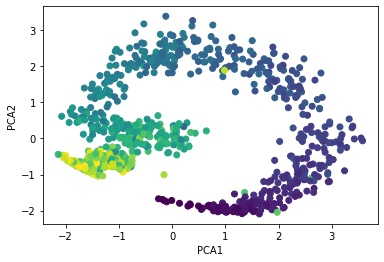

In [8]:
plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = adata.obs.dpt)
plt.xlabel("PCA1")
plt.ylabel("PCA2")

In [9]:
sc.tl.dpt(adata, n_branchings = 0)

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


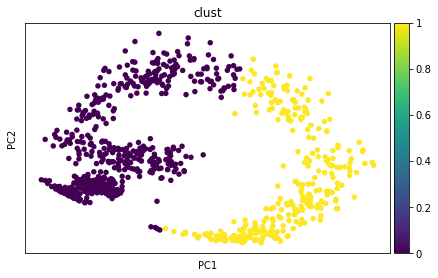

In [10]:
import sklearn as sk
from sklearn import cluster
adata.obs["clust"] = sk.cluster.KMeans(n_clusters = 2).fit_predict(adata.X)

sc.pl.scatter(adata, basis = "pca", color = "clust")

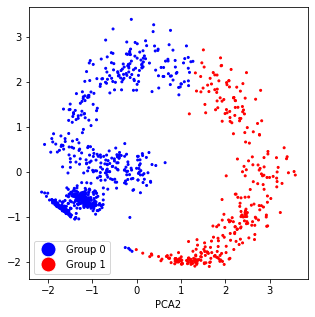

In [11]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
color_dict = {0 : "blue", 1 : "red"}
plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = [color_dict[x] for x in adata.obs.clust], s = 4)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Group 0', markerfacecolor='b', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Group 1', markerfacecolor='r', markersize=15), 
                   ]
plt.gca().legend(handles=legend_elements, loc='lower left')
plt.xlabel("PCA1")
plt.xlabel("PCA2")
plt.savefig(FIG_DIR + "sim_tsne.pdf")

In [16]:
# np.save(DATA_PATH + "X_tsne2.npy", adata.obsm["X_tsne"])
# np.save(DATA_PATH + "clusterid.npy", np.array([int(x) for x in adata.obs.clust]))

In [17]:
adata.obsm["X_tsne"] = np.load(DATA_PATH + "X_tsne2.npy")

In [347]:
# NMF
import networkx as nx
import os
import sys
sys.path.append("../../scripts")
import visutil

try:
    my_purple = matplotlib.colors.LinearSegmentedColormap.from_list("MyPurple", ['purple', 'purple', ])
    matplotlib.colormaps.register(cmap = my_purple)
    my_red = matplotlib.colors.LinearSegmentedColormap.from_list("MyRed", ['red', 'red', ])
    matplotlib.colormaps.register(cmap = my_red)
    my_grey = matplotlib.colors.LinearSegmentedColormap.from_list("MyGrey", ['#595959', '#595959', ])
    matplotlib.colormaps.register(cmap = my_grey)
except:
    pass

U = np.load(DATA_PATH + "U.npy")
V = np.load(DATA_PATH + "V.npy")
V = np.swapaxes(V.reshape(adata.shape[1], adata.shape[1], -1), 0, 1).reshape(adata.shape[1]**2, -1) # fix Julia orientation

In [348]:
import pygam
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in U.T]
U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
perm = np.argsort([adata.obs.dpt[np.argmax(x)] for x in U_gam.T])
U = U[:, perm]
U_gam = U_gam[:, perm]
V = V[:, perm]
del perm

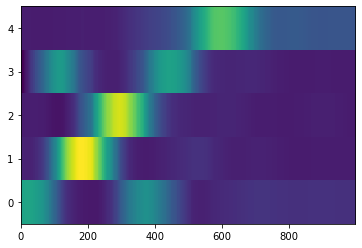

In [349]:
plt.imshow(U_gam[np.argsort(adata.obs.dpt), :].T, interpolation = "none", origin = "lower")
plt.axis("auto")
plt.savefig("switch_NMF_vs_pseudotime.pdf")

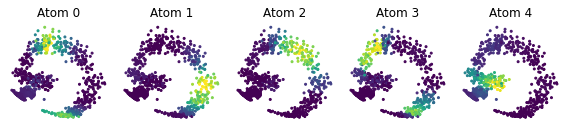

In [350]:
plt.figure(figsize = (8, 8))
for i in range(U.shape[1]):
    plt.subplot(5, 5, i+1)
    plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = U[:, i], s = 4, vmax = np.quantile(U[:, i], 0.99))
    plt.title("Atom {}".format(i))
    plt.axis("off")
plt.tight_layout()
plt.savefig("NMF_switch_modules_activities.pdf")

In [351]:
import ot 
import itertools
from tqdm import tqdm
import pandas as pd

C = np.zeros((U.shape[1], U.shape[1]))
for (i, j) in tqdm(itertools.product(range(U.shape[1]), range(U.shape[1]))):
    if i > j:
        C[i, j] = ot.emd2(U[:, i] / U[:, i].sum(), U[:, j] / U[:, j].sum(), adata.obsm["C"])
        C[j, i] = C[i, j]

25it [00:02, 12.44it/s]


/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


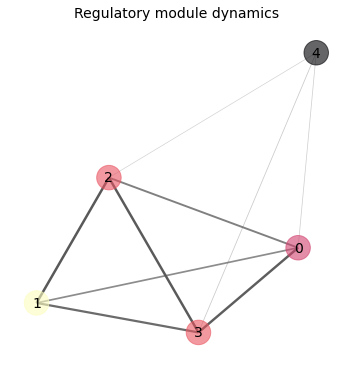

In [366]:
import sklearn as sk
from sklearn import neighbors

K = np.exp(-0.25*C / np.median(C))
K /= K.max()
t = np.array([visutil.approx_hitting_time(K / K.sum(-1).reshape(-1, 1), 1, j) for j in range(K.shape[0])])
g = nx.Graph(K)

nx.set_node_attributes(g, {i : np.exp(-t[i] / t.max()) for i in range(len(t))}, "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
# pos = nx.spectral_layout(g)
pos = nx.spring_layout(g)
# discard self loops
g.remove_edges_from(nx.selfloop_edges(g))
plt.figure(figsize = (5, 5))
module_names = {i : str(i) for i in range(K.shape[0])}
visutil.draw(g, 
             gene_names = [str(module_names[i]) if i in module_names.keys() else "" for i in range(K.shape[0])], 
             thresh = 0.0, pos = pos, 
             kwargs_nodes = {"cmap" : plt.cm.magma, "alpha" : [0.6 if i in module_names.keys() else 0.3 for i in range(K.shape[0])], }, 
             kwargs_edges = {})
plt.tight_layout()
plt.axis("off")
plt.title("Regulatory module dynamics", fontsize = 14)
plt.savefig("NMF_switch_modules.pdf")

In [367]:
g_all = []
for k in module_names.keys():
    A = V[:, k]
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    g_all += [g, ]
thresh = 0.8
g_agg, nodes, pos = visutil.get_union_graph(g_all, adata.var.index, thresh, layout_args = "-Gstart=1")

/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated/../../scripts/visutil.py:69: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_all = [np.array(nx.adjacency_matrix(g).todense()) for g in g_all]


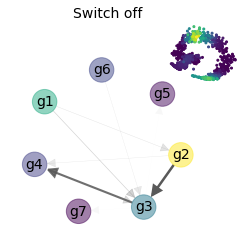

In [372]:
i = 0
A = V[:, i].reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (3.5, 3.5))
plt.margins(x = 0.125, y = 0.125)
# visutil.draw(g, adata.var.index, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
visutil.draw(g, adata.var.index, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = U[:, i]
axin.scatter(adata.obsm["X_pca"][np.argsort(p), 0], adata.obsm["X_pca"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("")
plt.title("Switch off", fontsize = 14)
plt.tight_layout()
plt.savefig("switch_NMF_off.pdf")

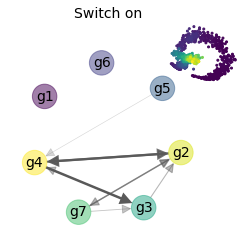

In [373]:
i = 4
A = V[:, i].reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (3.5, 3.5))
plt.margins(x = 0.125, y = 0.125)
# visutil.draw(g, adata.var.index, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
visutil.draw(g, adata.var.index, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = U[:, i]
axin.scatter(adata.obsm["X_pca"][np.argsort(p), 0], adata.obsm["X_pca"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("")
plt.title("Switch on", fontsize = 14)
plt.tight_layout()
plt.savefig("switch_NMF_on.pdf")

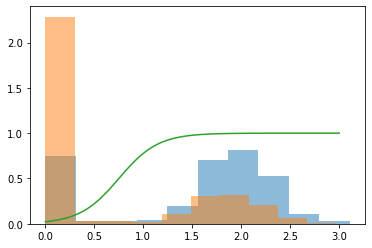

In [392]:
x_g6 = adata.X[:, np.where(adata.var.index == 'g6')[0]]
x_g5 = adata.X[:, np.where(adata.var.index == 'g5')[0]]

plt.hist(x_g6, alpha = 0.5, density = True)
plt.hist(x_g5, alpha = 0.5, density = True)

sigmoid = lambda x: 1 / (1 + np.exp(-x))
f = lambda x: sigmoid(5*(x-0.75))

xs = np.linspace(0, 3, 100)
ys = f(xs)
plt.plot(xs, ys, label = "Binary")

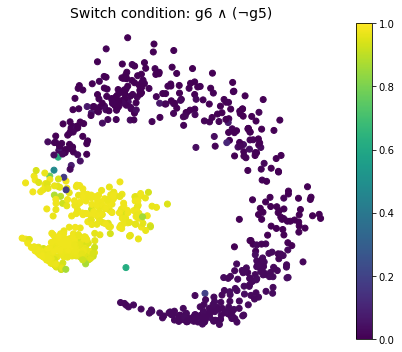

In [393]:
b_g6_not_g5 = f(x_g6) * (1 - f(x_g5))

plt.figure(figsize = (6, 5))
plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = b_g6_not_g5, vmin = 0, vmax = 1)
plt.title("Switch condition: g6 ∧ (¬g5)", fontsize = 14)
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.savefig("switch_condition.pdf")

In [409]:
# NTF
import seaborn as sb
for i in range(3):
    adata.uns["A_{}".format(i)] = np.load(DATA_PATH + "A_{}.npy".format(i+1))
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in adata.uns["A_0"].T]
U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
perm = np.argsort([np.dot(adata.obs.dpt, x / sum(x)) for x in U_gam.T])
adata.uns["A_0"] = adata.uns["A_0"][:, perm]
adata.uns["A_1"] = adata.uns["A_1"][:, perm]
adata.uns["A_2"] = adata.uns["A_2"][:, perm]
U_gam = U_gam[:, perm]
del perm

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(331.49999999999994, 0.5, 'Regulatory module')

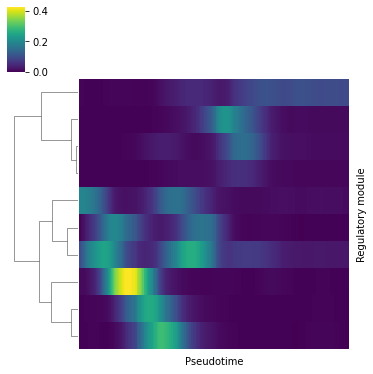

In [410]:
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis")
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Regulatory module")

Text(331.50000000000006, 0.5, 'Regulatory module')

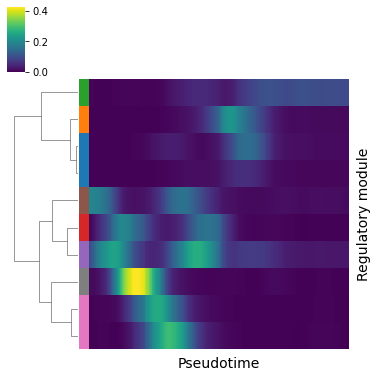

In [411]:
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster
Z = cg.dendrogram_row.calculated_linkage
clusterids = fcluster(Z, 8, criterion = 'maxclust')
colordict = {i : matplotlib.cm.get_cmap('tab10')(i-1) for i in range(1, len(np.unique(clusterids))+1)}
clusterdict = {k : "cluster_{}".format(k) for k in np.unique(clusterids)}
colors = [colordict[i] for i in clusterids]

from matplotlib.patches import Patch
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", row_colors = colors, rasterized = True)
cg.ax_heatmap.set_xlabel("Pseudotime", fontsize = 14)
cg.ax_heatmap.set_ylabel("Regulatory module", fontsize = 14)

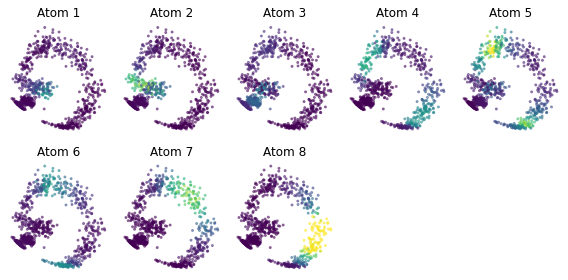

In [412]:
plt.figure(figsize = (8, 4))
for i in np.unique(clusterids):
    plt.subplot(2, 5, i)
    plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = adata.uns["A_0"][:, clusterids == i].mean(-1), s = 4, vmax = np.quantile(adata.uns["A_0"], 0.99), alpha = 0.5)
    plt.title("Atom {}".format(i))
    plt.axis("off")
plt.tight_layout()

In [413]:
import ot 
import itertools
from tqdm import tqdm
import pandas as pd

C = np.zeros((adata.uns["A_0"].shape[1], adata.uns["A_0"].shape[1]))
for (i, j) in tqdm(itertools.product(range(adata.uns["A_0"].shape[1]), range(adata.uns["A_0"].shape[1]))):
    if i > j:
        C[i, j] = ot.emd2(adata.uns["A_0"][:, i] / adata.uns["A_0"][:, i].sum(), adata.uns["A_0"][:, j] / adata.uns["A_0"][:, j].sum(), adata.obsm["C"])
        C[j, i] = C[i, j]

100it [00:09, 10.24it/s]


/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Text(0.5, 1.0, 'Regulatory module dynamics')

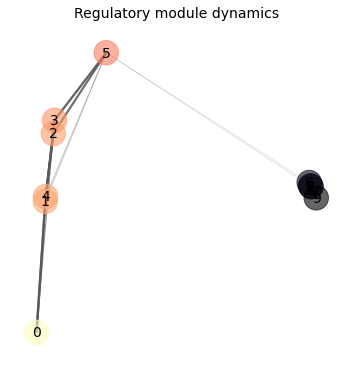

In [414]:
import sklearn as sk
from sklearn import neighbors
A = sk.neighbors.NearestNeighbors(n_neighbors=5, metric = 'precomputed').fit(C).kneighbors_graph(C).toarray()
A = 0.5*(A + A.T)
K = np.exp(-0.5*C / np.median(C)) * A
K /= K.max()
t = np.array([visutil.approx_hitting_time(K / K.sum(-1).reshape(-1, 1), 0, j) for j in range(K.shape[0])])
g = nx.Graph(K)

nx.set_node_attributes(g, {i : np.exp(-t[i] / t.max()) for i in range(len(t))}, "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
pos = nx.spectral_layout(g)
# pos = nx.spring_layout(g)
# discard self loops
g.remove_edges_from(nx.selfloop_edges(g))
plt.figure(figsize = (5, 5))
module_names = {i : str(i) for i in range(K.shape[0])}
visutil.draw(g, 
             gene_names = [str(module_names[i]) if i in module_names.keys() else "" for i in range(K.shape[0])], 
             thresh = 0.0, pos = pos, 
             kwargs_nodes = {"cmap" : plt.cm.magma, "alpha" : [0.6 if i in module_names.keys() else 0.3 for i in range(K.shape[0])], }, 
             kwargs_edges = {})
plt.tight_layout()
plt.axis("off")
plt.title("Regulatory module dynamics", fontsize = 14)

In [415]:
g_all = []
for k in range(adata.uns["A_0"].shape[1]):
    A = np.outer(adata.uns["A_1"][:, k].T, adata.uns["A_2"][:, k].T)
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    g_all += [g, ]
thresh = 0.8
_, nodes, pos = visutil.get_union_graph(g_all, adata.var.index, thresh, layout_args = "-Gstart=1")

/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated/../../scripts/visutil.py:69: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_all = [np.array(nx.adjacency_matrix(g).todense()) for g in g_all]


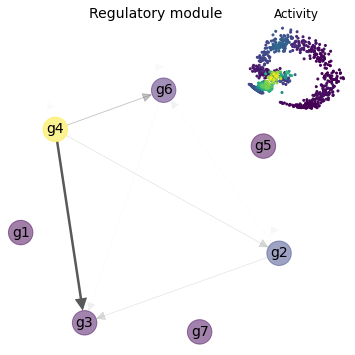

In [429]:
i = 9
A = np.outer(adata.uns["A_1"][:, i].T, adata.uns["A_2"][:, i].T)
g = nx.DiGraph(A)
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (5, 5))
# visutil.draw(g, adata.var.gene, thresh = 0.9975, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
visutil.draw(g, adata.var.index, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = adata.uns["A_0"][:, i]
axin.scatter(adata.obsm["X_pca"][np.argsort(p), 0], adata.obsm["X_pca"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("Activity")
plt.title("Regulatory module", fontsize = 14)
plt.tight_layout()